### Nacteni dat



In [18]:
import pandas as pd

# 'data/csv/out_B.csv'
# 'data/csv/out_ret.csv'
# 'data/csv/out_smz.csv'
# 'data/csv/out_int.csv'
# 'data/csv/out_cle.csv'

database_type = 'cle'

path = 'data/csv/out_{}.csv'.format(database_type)

# Cesta k nasim datum
csv_data = path

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')
# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


Abychom nemuseli psát stejný kód několikrát, napíšeme si kód do funkce, kterou pak jednoduše zavoláme. 

In [19]:
# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    for item in strings:
        if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
            flattened_list.append(item)
        else:  # Rekurzivne zavola sebe
            flattened_list.extend(flatten_list(item))
    return flattened_list

### Úprava 

K časopisu je zpravidla připsáno i místo vydání. Pro naše účely nám stačí ale jen název časopisu. Proto pomocí regulárního výrazu (regex) odstraníme místo vydání, které je napsané buď v kulatých, nebo hranatých závorkách. 

In [22]:
import re
import numpy as np

# regex patern, ktery najde substring pred zavorkou
# r"^(.*?)\s*(?=\()" <- kulate zavorky
pattern_magazine = r"^(.*?)\s*(?=\()"   #r"(.*?)\[" # <- hranate zavory  

# Odstranime misto vydani v zavore (pokud je pritomno)
df['magazine'] = df['magazine'].apply(lambda x: [re.search(pattern_magazine, y).group(1) if re.search(pattern_magazine, y) else y for y in x])

# Zbavime se prebytecnych mezer na zacatku a na konci stringu
df['magazine'] = df['magazine'].apply(lambda x: [y.rstrip() for y in x])

unique_magazine = np.unique(flatten_list(df.magazine))
print(unique_magazine)

49
49


### Zpracování

In [25]:
from collections import Counter 

author_code_column = 'author code'

# Vsichni autori ve sloupci
all_authors = flatten_list(df[author_code_column])

# Spocteme, v kolika zaznamech se autor objevil
counted_authors = Counter(all_authors)

# Pocet uzlu, ktere chceme vykreslit
n = 10

# Najdeme nejcastejsi autory, ktere pak zobrazime
most_common_authors = [item[0] for item in counted_authors.most_common(n)]

print(most_common_authors)

# Sloupec, ktery chceme zobrazit.
column = 'magazine'

# Zjistime indexy vsech radku, kde se objevuji autori, ktere chceme zobrazit 
ind = [True if any([True if author in most_common_authors else False for author in author_list]) else False for author_list in df[author_code_column]]

author_elements = df[ind][column]

unique_author_elements = np.unique(flatten_list(author_elements)) #find_unique(author_elements)

['jk01023057', 'jk01062954', 'jk01022204', 'jk01130413', 'jk01081347', 'jk01062535', 'jk01150030', 'xx0180607', 'jk01130395', 'kpwa5009']
35
35


#### Mapping

Přiřadíme ke kódu autora jeho jméno

In [13]:
mapping = {}
most_common_authors_copy = most_common_authors.copy()
for idx,row in df.iterrows():
        if any(item in most_common_authors_copy for item in row[author_code_column]):
                for i, item in enumerate(row[author_code_column]):
                        if item in most_common_authors_copy:
                                mapping[item] = row['author'][i]
                                most_common_authors_copy.remove(item)
        if len(most_common_authors_copy)<1:
                break                                


### Vytvoření struktury grafu


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


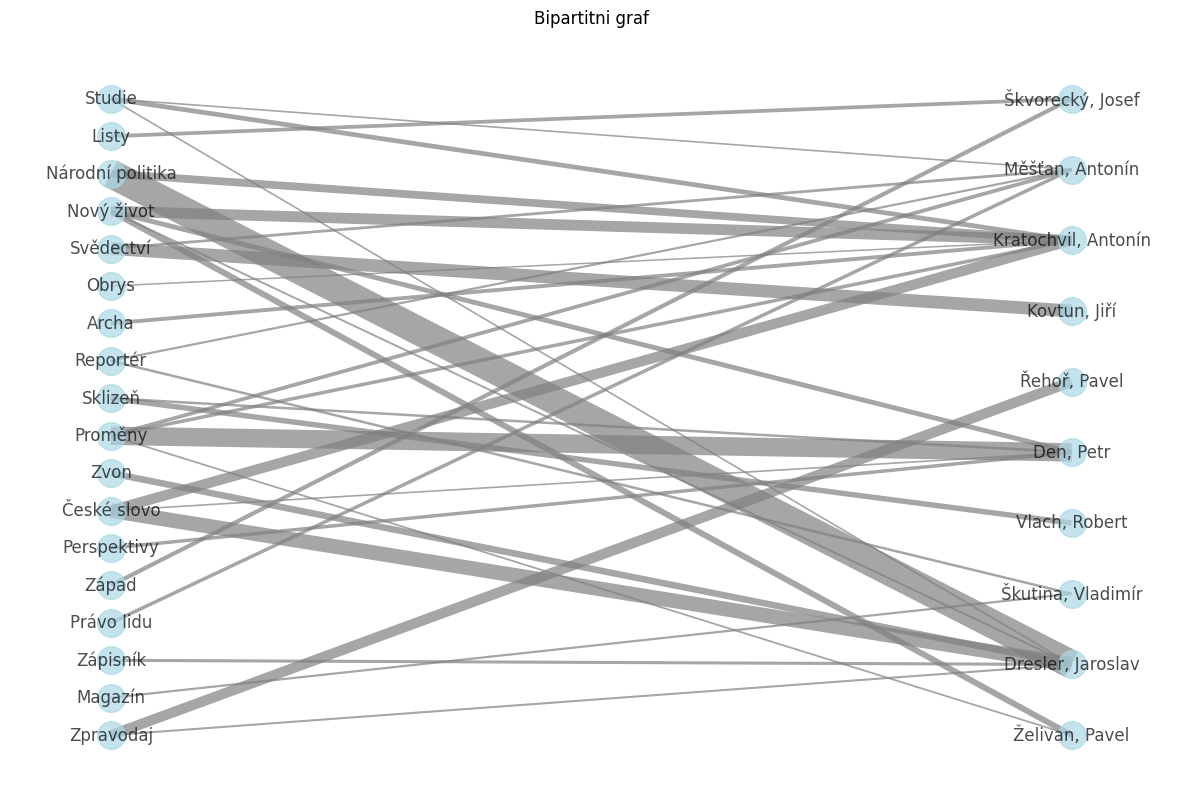

In [16]:
%pip install networkx
%pip install matplotlib

import networkx as nx
import matplotlib.pyplot as plt

# Vytvorime graf
G = nx.Graph()

# Elementy pridame grafu jako uzle
G.add_nodes_from(most_common_authors, bipartite=1)

# Vahy hran. Cim vice clanku v casopisu, tim vyssi vaha.
# Ve vykreslenem grafu pak bude vyssi vaha mit silnejsi caru. 
edge_weights = {}

# Iterujeme pres vsechny clanky
for _,row in df.iterrows():
    for element in row[column]:
        for author in row[author_code_column]:
            # Chceme vyselektovat jen desen nejcastejsich elemenu a casopisu
            if element in unique_author_elements and author in most_common_authors:
                if  (author, element) in edge_weights:
                    # Do dictionary hrany pridavame jako tuple 
                    edge_weights[(author, element)] += 1
                else:
                    edge_weights[(author, element)] = 1

# Vykreslime jen ty casopisy, ktere se objevuji vicekrat  
threshold = 10
left = []

for edge, weight in edge_weights.items():
    if weight>threshold:
        if ~G.has_node(edge[1]):
            left.append(edge[1])
            G.add_node(edge[1], bipartite=0) 
        G.add_edge(edge[0], edge[1], weight=weight)                

# Ke kodu autora pridame jeho skutecne jmeno
G = nx.relabel_nodes(G, mapping)

### Vykreslení grafu

In [ ]:
pos = nx.bipartite_layout(G, nodes = left)
plt.figure(figsize=(15, 10))
edge_widths = [0.1 * G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=400,
                 width=edge_widths, edge_color='gray', alpha=0.7)
plt.title("Bipartitni graf")
plt.axis("off")
plt.show()